<a href="https://colab.research.google.com/github/naguzmans/opportunistic-utm/blob/master/01_Download_Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies

In [ ]:
!pip install holidays
%cd /content/drive/MyDrive/opportunistic-utm/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/opportunistic-utm


# Check DarkSky API

In [ ]:
import requests

# Checks API using a random timestamp
timestamp = 1526745600
key = '00fa20d9a815fab822b59c022ba8f4e5'
location = '51.87626460000001,-0.3717470999999932'
exclude = 'exclude=minutely,hourly,daily,alerts,flags'
units = 'si'
endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
requests.get(endpoint).json()['currently']

{'apparentTemperature': 19.02,
 'dewPoint': 4.03,
 'humidity': 0.37,
 'temperature': 19.02,
 'time': 1526745600,
 'visibility': 10.003,
 'windBearing': 89,
 'windSpeed': 10.38}

# Define Metadata Functions

In [ ]:
from datetime import datetime
import numpy as np
import holidays
import math
import requests

# Transforms Unix time to UTC
def epoch_to_utc(hour_in_unix_time):
  return datetime.utcfromtimestamp(hour_in_unix_time)

# Gets month number
def get_month(unix_timestamp):
  return unix_timestamp.month

# Gets week number
def get_day(unix_timestamp):
  return unix_timestamp.weekday()

# Checks if given timestamp is holiday or not in the UK
def is_holiday(timestamp):
  uk_holidays = holidays.UK()

  if timestamp in uk_holidays:
    return 1
  else:
    return 0

# Gets weather information using DarkSky API
def get_weather(unix_timestamp, size = 100):
  timestamp = str(unix_timestamp)
  key = 'INSERT YOUR KEY'
  location = '51.87626460000001,-0.3717470999999932'
  exclude = 'exclude=minutely,hourly,daily,alerts,flags'
  units = 'si'
  endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
  response = requests.get(endpoint).json()['currently']

  try:
    temperature = np.reshape(response['temperature'], (1,1))
  except:
    temperature = np.reshape(np.nan, (1,1))

  try:
    wind_bearing = np.reshape(response['windBearing'], (1,1))
  except:
    wind_bearing = np.reshape(np.nan, (1,1))

  try:
    wind_speed = np.reshape(response['windSpeed'], (1,1))
  except:
    wind_speed = np.reshape(np.nan, (1,1))
  
  try:
    visibility = np.reshape(response['visibility'], (1,1))
  except:
    visibility = np.reshape(np.nan, (1,1))

  try:
    humidity = np.reshape(response['humidity'], (1,1))
  except:
    humidity = np.reshape(np.nan, (1,1))

  weather_metadata = np.concatenate((temperature, wind_bearing, wind_speed, visibility, humidity), axis = 1)
  return np.tile(weather_metadata, (size, 1))

# Blank spacer if data is no a multiple of five
def spacer(units):
  return np.zeros(units)

# Compile metadata
def metadata(timestamp, size = 100, tiled = False):
  utc_timestamp = epoch_to_utc(timestamp)

  # Hot-encode day and month
  months = np.zeros(12)
  days = np.zeros(7)
  months[get_month(utc_timestamp)-1] = 1
  days[get_day(utc_timestamp)] = 1
  months_tile = np.tile(months, (size, 1))
  days_tile = np.tile(days, (size, 1))

  # Hot-enconde if holiday is true
  holiday_tile = np.tile(is_holiday(utc_timestamp), (size, 1))

  # Weather
  weather_tile = get_weather(timestamp, size=size)

  # Spacer if needed
  spacer_tile = np.tile(spacer(1), (size, 1))

  tiled_metadata = np.concatenate((months_tile, days_tile, holiday_tile, weather_tile), axis = 1)

  # Merge together
  if tiled == True:
    width = math.ceil(size/tiled_metadata.shape[-1])
    tiled_metadata = np.tile(tiled_metadata, width)[:,:size]
    return tiled_metadata
  elif tiled == False:
    return tiled_metadata[0]

# Test Sample

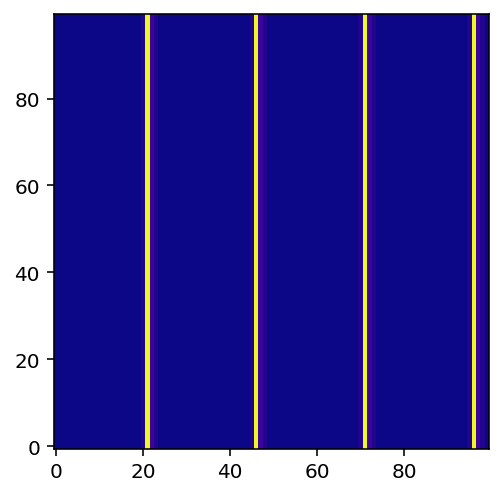

In [ ]:
# Plot as a tile of (100, 100)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plot_metadata = metadata(1546339684, tiled = True)
plt.imshow(plot_metadata, origin='lower', cmap='plasma')
plt.show()

In [ ]:
# Check metadata shape
metadata(1517440800)

array([  1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.98 ,
       235.   ,  20.67 ,  10.003,   0.83 ])

# Download Metadata

In [ ]:
from datetime import timezone
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Download data manually as needed
year = 2017
days = np.linspace(1,31,31)

columns = ['time', 'hour', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', \
           'oct', 'nov', 'dec', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',\
           'hol', 'temp', 'wbear', 'wspeed', 'visib', 'humid']
metadata_df = pd.DataFrame(columns = columns)

# Iterates through each day in a given month
for month in tqdm(range(1, 13)):
  try:
    for day in days:
      unix_hour = int(datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp())
      for i in range(0, 24):
        for j in range(3):
          base_hour = np.reshape(np.array(unix_hour), (1,))
          next_20 = np.reshape(np.array(unix_hour + j * 1200), (1,))
          metadata_array = np.concatenate((next_20, base_hour, metadata(unix_hour + j * 1200)))
          metadata_df = metadata_df.append(pd.DataFrame(metadata_array.reshape(1,-1), columns=columns))
        unix_hour += 3600
    metadata_df = metadata_df.reset_index(drop=True)
  except:
    print('End of Month')

# Save file
filepath = f'dataset/00_results/metadata_{year}.xlsx'
metadata_df.to_excel(filepath, index=False)

 17%|█▋        | 2/12 [23:52<1:58:18, 709.90s/it]

End of Month


 33%|███▎      | 4/12 [48:36<1:37:20, 730.09s/it]

End of Month


 50%|█████     | 6/12 [1:13:19<1:13:33, 735.57s/it]

End of Month


 75%|███████▌  | 9/12 [1:50:37<37:02, 740.72s/it]

End of Month


 92%|█████████▏| 11/12 [2:15:05<12:15, 735.85s/it]

End of Month


100%|██████████| 12/12 [2:27:25<00:00, 737.09s/it]


# Process Metadata

**Load & Merge Data**

In [ ]:
import pandas as pd

# df_2017 = pd.read_excel(f'dataset/00_results/metadata_2017.xlsx')
df_2018 = pd.read_excel(f'dataset/00_results/metadata_2018.xlsx')
df_2019 = pd.read_excel(f'dataset/00_results/metadata_2019.xlsx')

metadata_df = pd.concat([df_2018, df_2019]).reset_index(drop=True)
metadata_df = metadata_df[['time', 'hour', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', \
           'oct', 'nov', 'dec', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',\
           'hol', 'temp', 'humid', 'wbear', 'wspeed', 'visib']]
metadata_df.describe()

,time,hour,jan,feb,mar,apr,may,jun,jul,aug,...,thu,fri,sat,sun,hol,temp,humid,wbear,wspeed,visib
count,5.256000e+04,5.256000e+04,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,...,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52149.000000,52149.000000,51999.000000,51999.000000,51966.000000
mean,1.546300e+09,1.546299e+09,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,...,0.142466,0.142466,0.142466,0.142466,0.038356,10.666576,0.805585,189.713918,15.926023,8.922389
std,1.820749e+07,1.820749e+07,0.278782,0.266137,0.278782,0.274659,0.278782,0.274659,0.278782,0.278782,...,0.349531,0.349531,0.349531,0.349531,0.192056,6.411300,0.168423,95.288631,7.703892,2.424725
min,1.514765e+09,1.514765e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.190000,0.000000,0.000000,0.000000
25%,1.530532e+09,1.530532e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.010000,0.710000,124.000000,10.210000,9.981250
50%,1.546300e+09,1.546299e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.860000,205.000000,14.750000,10.003000
75%,1.562068e+09,1.562066e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.010000,0.930000,259.000000,20.480000,10.003000
max,1.577836e+09,1.577833e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,37.280000,1.000000,359.000000,62.840000,10.769000


In [ ]:
metadata_df.head()

,time,hour,jan,feb,mar,apr,may,jun,jul,aug,...,thu,fri,sat,sun,hol,temp,humid,wbear,wspeed,visib
0,1483228800,1483228800,1,0,0,0,0,0,0,0,...,0,0,0,1,1,6.02,1.00,210.0,16.82,6.988
1,1483230000,1483228800,1,0,0,0,0,0,0,0,...,0,0,0,1,1,5.95,1.00,207.0,16.60,6.874
2,1483231200,1483228800,1,0,0,0,0,0,0,0,...,0,0,0,1,1,5.98,1.00,203.0,15.89,7.090
3,1483232400,1483232400,1,0,0,0,0,0,0,0,...,0,0,0,1,1,6.00,1.00,200.0,15.48,6.979
4,1483233600,1483232400,1,0,0,0,0,0,0,0,...,0,0,0,1,1,6.03,0.98,203.0,15.86,6.083


**Impute Missing Values**

In [ ]:
metadata_df['temp'].fillna(method='ffill', inplace=True)
metadata_df['humid'].fillna(method='ffill', inplace=True)
metadata_df['wbear'].fillna(method='ffill', inplace=True)
metadata_df['wspeed'].fillna(method='ffill', inplace=True)
metadata_df['visib'].fillna(method='ffill', inplace=True)

**Group by Hour**

In [ ]:
metadata = metadata_df.groupby(['hour'], as_index=False).agg({\
        'jan': 'first', 'feb': 'first', 'mar': 'first', 'apr': 'first', 'may':'first', \
        'jun':'first','jul':'first','aug':'first','sep':'first','oct':'first', \
        'nov':'first', 'dec':'first', 'mon':'first', 'tue':'first', 'wed':'first', \
        'thu':'first', 'fri':'first', 'sat':'first', 'sun':'first', 'hol':'first',  \
        'temp':'mean', 'humid':'mean', 'wbear':'mean','wspeed':'mean', 'visib':'mean'}).reset_index(drop=True)

In [ ]:
metadata.describe()

,hour,jan,feb,mar,apr,may,jun,jul,aug,sep,...,thu,fri,sat,sun,hol,temp,humid,wbear,wspeed,visib
count,1.752000e+04,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,...,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,1.546299e+09,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.142466,0.142466,0.142466,0.142466,0.038356,10.670991,0.805317,189.775590,15.935600,8.924493
std,1.820784e+07,0.278788,0.266142,0.278788,0.274665,0.278788,0.274665,0.278788,0.278788,0.274665,...,0.349537,0.349537,0.349537,0.349537,0.192060,6.403204,0.167803,92.028593,7.639424,2.391378
min,1.514765e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.970000,0.196667,0.000000,0.350000,0.020000
25%,1.530532e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.010000,0.710000,126.666667,10.275833,9.952000
50%,1.546299e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.973333,0.853333,205.333333,14.710000,10.003000
75%,1.562066e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.013333,0.933333,255.333333,20.310000,10.003000
max,1.577833e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,37.173333,1.000000,354.666667,61.490000,10.496667


**Scale**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
metadata[['temp', 'humid', 'wbear', 'wspeed', 'visib']] = scaler.fit_transform(metadata[['temp', 'humid', 'wbear', 'wspeed', 'visib']])

**Check**

In [ ]:
metadata.describe()

,hour,jan,feb,mar,apr,may,jun,jul,aug,sep,...,thu,fri,sat,sun,hol,temp,humid,wbear,wspeed,visib
count,1.752000e+04,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,...,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,1.546299e+09,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.142466,0.142466,0.142466,0.142466,0.038356,0.399630,0.757656,0.535082,0.254917,0.849936
std,1.820784e+07,0.278788,0.266142,0.278788,0.274665,0.278788,0.274665,0.278788,0.278788,0.274665,...,0.349537,0.349537,0.349537,0.349537,0.192060,0.145055,0.208883,0.259479,0.124950,0.228258
min,1.514765e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.530532e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.294042,0.639004,0.357143,0.162346,0.948011
50%,1.546299e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.383825,0.817427,0.578947,0.234871,0.952879
75%,1.562066e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.497999,0.917012,0.719925,0.326464,0.952879
max,1.577833e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Save Files**

In [ ]:
from datetime import datetime
from tqdm import tqdm
import os

for i in tqdm(range(0, len(metadata))):
  row_hour = metadata['hour'][i]
  str_year = datetime.utcfromtimestamp(row_hour).strftime('%Y')
  str_month = datetime.utcfromtimestamp(row_hour).strftime('%m')
  str_day = datetime.utcfromtimestamp(row_hour).strftime('%d')
  saving_folder = f'dataset/{str_year}-{str_month}/{str_year}-{str_month}-{str_day}/metadata'

  if not os.path.exists(f'{saving_folder}'):
    os.makedirs(f'{saving_folder}')

  metadata_array = metadata[metadata['hour'] == row_hour].reset_index(drop=True).values[0][1:]
  np.save(f'{saving_folder}/{str(row_hour)}.npy', metadata_array)

100%|██████████| 17520/17520 [2:19:15<00:00,  2.10it/s]
